Lorena Ciutacu | SPICED Academy | Stochastic Sage | Week 3

## Use regression models and feature engineering techniques to predict bike share demand.

## SETUP

In [35]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, PassiveAggressiveRegressor, ElasticNetCV
from tpot import TPOTRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, cross_validate
from statsmodels.api import OLS, add_constant
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score

In [2]:
df_train = pd.read_csv('bikes_train.csv')

## FEATURE ENGINEERING

In [3]:
# extract year, month, day, weekday, and hour from datetime

df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train['year'] = df_train['datetime'].dt.year
df_train['month'] = df_train['datetime'].dt.month
df_train['day'] = df_train['datetime'].dt.day
df_train['weekday'] = df_train['datetime'].dt.dayofweek
df_train['hour'] = df_train['datetime'].dt.hour

In [4]:
# split weather values into 4 columns

weather = pd.get_dummies(df_train['weather'], prefix='weather')
df_train = pd.concat([df_train, weather], axis=1)

In [5]:
df_train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,year,month,day,weekday,hour,weather_1,weather_2,weather_3,weather_4
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,...,336,2012,12,19,2,19,1,0,0,0
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,...,241,2012,12,19,2,20,1,0,0,0
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,...,168,2012,12,19,2,21,1,0,0,0
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,...,129,2012,12,19,2,22,1,0,0,0
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,...,88,2012,12,19,2,23,1,0,0,0


In [18]:
df_train = df_train.set_index('datetime')
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour,weather_1,weather_2,weather_3,weather_4
datetime,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0,1,0,0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1,1,0,0,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2,1,0,0,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3,1,0,0,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4,1,0,0,0


In [19]:
# split into train-test

#X = df_train[['season','holiday','workingday','temp','humidity','windspeed','hour','weekday']]
X = df_train[['temp','hour','weather','weekday','holiday']]
y = df_train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
ylog_train = np.log1p(y_train)
ylog_test = np.log1p(y_test)

In [21]:
# fill in missing values

impute_frequent = make_pipeline(
    SimpleImputer(strategy='most_frequent')
)

impute_scale = make_pipeline(
    SimpleImputer(strategy='median'),
    MinMaxScaler(feature_range=(0,1))
)

In [22]:
ct = ColumnTransformer([
    ('impute', impute_frequent, ['weekday','weather','holiday']),
    ('impute_scale', impute_scale, ['temp','hour'])
])

ct.fit(X_train)
X_train_trans = ct.transform(X_train)

## FEATURE SELECTION

In [23]:
rfr = RandomForestRegressor()
rfe = RFE(rfr)
rfe.fit(X_train, y_train)

print(rfe.support_)  # booleans indicating features to include
print(rfe.ranking_)  # integers indicating importance
# 'season','holiday','workingday','temp','humidity','windspeed','hour','weekday' --> temp, humidity, hour, weekday

[ True  True False False False]
[1 1 3 2 4]


In [24]:
rfr_sm = OLS(endog=y_train, exog=X_train)
results = rfr_sm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.662
Method:                 Least Squares   F-statistic:                              3409.
Date:                Fri, 16 Oct 2020   Prob (F-statistic):                        0.00
Time:                        22:06:11   Log-Likelihood:                         -56175.
No. Observations:                8708   AIC:                                  1.124e+05
Df Residuals:                    8703   BIC:                                  1.124e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           7.2056      0.171     42.160      0.000       6.871       7.541
hour           8.8548      0.228     38.888      0.000       8.408       9.301
weather      -36.0019      2.116    -17.014      0.000     -40.150     -31.854
weekday       -1.1953      0.762     -1.570      0.117      -2.688       0.298
holiday      -15.6913      9.862     -1.591      0.112     -35.023       3.640
==============================================================================
Omnibus:                     1958.706   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4089.347
Skew:                           1.322   Prob(JB):                         0.00
Kurtosis:                       5.070   Cond. No.                         149.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## REGRESSION MODELS

## Random Forest Regressor

In [25]:
# basic rfr
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
ypred_rfr0 = rfr.predict(X_test)

print(f' RFR R² train: {round(rfr.score(X_train, y_train), 2)}')
print(f' RFR R² test: {round(rfr.score(X_test, ypred_rfr0), 2)}')
print(f' RFR RSMLE: {round(np.sqrt(mean_squared_log_error(y_test, ypred_rfr0)), 2)}')

 RFR R² train: 0.93
 RFR R² test: 1.0
 RFR RSMLE: 0.49


In [26]:
# cross val. 
cross_validate(rfr, X_train, y_train,return_train_score=True)

{'fit_time': array([1.76446605, 1.59776235, 2.01748157, 2.07701278, 2.0185163 ]),
 'score_time': array([0.06421685, 0.07472134, 0.07356143, 0.07176328, 0.07902694]),
 'test_score': array([0.77697372, 0.77500699, 0.78432143, 0.78286823, 0.77693894]),
 'train_score': array([0.93873897, 0.94114662, 0.93991912, 0.93753628, 0.93758791])}

In [15]:
print('RFR avg. cross validation score:', round(cross_val_score(rfr, X_train, y_train).mean(), 2))
print('RFR avg. std:', round(cross_val_score(rfr, X_train, y_train).std(), 2))

RFR avg. cross validation score: 0.78
RFR avg. std: 0.0


### Hyperparameter Optimization

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [73]:
param_grid = {
    'max_depth': [1, 5, 10, 20, 50, None],
    'n_estimators': [1, 5, 10, 20, 50, 100]
}

In [75]:
# Create a gridsearch
gridsearch = GridSearchCV(rfr, param_grid, cv=ShuffleSplit(n_splits=3))

In [76]:
# Fit the gridsearch
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=None, train_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10, 20, 50, None],
                         'n_estimators': [1, 5, 10, 20, 50, 100]})

In [77]:
# Find the "best" hyperparameters
gridsearch.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [78]:
# Inspect the results on a more granular level
pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
17,0.519958,0.004688,0.014356,0.000316,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.826453,0.794128,0.832700,0.817761,0.016904,1
16,0.261609,0.003676,0.008607,0.000678,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.824934,0.794522,0.830956,0.816804,0.015946,2
15,0.103411,0.001495,0.004208,0.000046,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.823698,0.792774,0.831710,0.816061,0.016788,3
14,0.051847,0.000079,0.003047,0.000065,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.821755,0.789177,0.831754,0.814229,0.018179,4
13,0.027131,0.000421,0.002422,0.000034,10,5,"{'max_depth': 10, 'n_estimators': 5}",0.820528,0.782982,0.829889,0.811133,0.020269,5
29,0.824367,0.023621,0.023482,0.000979,50,100,"{'max_depth': 50, 'n_estimators': 100}",0.790244,0.771243,0.786233,0.782573,0.008177,6
22,0.402033,0.011183,0.013216,0.000220,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.790376,0.771233,0.784559,0.782056,0.008013,7
23,0.770685,0.003067,0.023525,0.000450,20,100,"{'max_depth': 20, 'n_estimators': 100}",0.791956,0.769452,0.784486,0.781965,0.009359,8
35,0.786616,0.003250,0.024160,0.000397,None,100,"{'max_depth': None, 'n_estimators': 100}",0.789390,0.769373,0.781365,0.780043,0.008225,9
21,0.163283,0.000191,0.006789,0.000129,20,20,"{'max_depth': 20, 'n_estimators': 20}",0.784634,0.768307,0.785591,0.779511,0.007932,10


In [27]:
# retrain RFR with suggested hyperparameters

rfr_new = RandomForestRegressor(max_depth=10, n_estimators=100)

In [28]:
rfr_new.fit(X_train, y_train)
pred_rfr_new = rfr_new.predict(X_test)
print('RFR_optimized R² train:', rfr_new.score(X_train, y_train))
print('RFR_optimized R² test:', rfr_new.score(X_test, pred_rfr_new))
print('RFR_optimized RMSLE test:', np.sqrt(mean_squared_log_error(y_test, pred_rfr_new)))

RFR_optimized R² train: 0.8510365563535625
RFR_optimized R² test: 1.0
RFR_optimized RMSLE test: 0.4690916720089186


In [57]:
rfr_new.fit(X_train, ylog_train)
rfrnew_log_pred = rfr_new.predict(X_test)
print('RFR_optimized RMSLE (log):', np.sqrt(mean_squared_log_error(ylog_test, rfrnew_log_pred)))

RFR_optimized RMSLE (log): 0.107525786191065


In [315]:
# TPOT: auto-ML to find the best model with hyperparameters.

tpot = TPOTRegressor(
    generations=3,
    population_size=10,
    scoring='accuracy',
    #verbosity=2,
    random_state=42)

tpot.fit(X_train, y_train)

Optimization Progress: 100%|██████████| 40/40 [02:36<00:00,  2.31s/pipeline]

Best pipeline: RandomForestRegressor(CombineDFs(input_matrix, input_matrix), bootstrap=True, max_features=0.4, min_samples_leaf=7, min_samples_split=13, n_estimators=100)


-6133.551980346076

In [29]:
# RFR with hyperparameters recommended by TPOT
# ElasticNetCV(RandomForestRegressor(bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=7, min_samples_split=19, n_estimators=100), l1_ratio=0.45, tol=0.001) --> TypeError: unsupported operand type(s) for *: 'int' and 'RandomForestRegressor'

rfr_tpot = RandomForestRegressor(bootstrap=True, max_features=0.9000000000000001, min_samples_leaf=7, min_samples_split=19, n_estimators=100)

rfr_tpot.fit(X_train, y_train)
pred_rfr_tpot = rfr_tpot.predict(X_test)
print('RFR_tpot R² train:', rfr_tpot.score(X_train, y_train))
print('RFR_tpot R² test:', rfr_tpot.score(X_test, pred_rfr_tpot))
print('RFR_tpot RMSLE test:', np.sqrt(mean_squared_log_error(y_test, pred_rfr_tpot)))

RFR_tpot R² train: 0.8514644399874056
RFR_tpot R² test: 1.0
RFR_tpot RMSLE test: 0.47642215292501033


## Gradient Boosting Regression

In [52]:
# GBR

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=400, alpha=0.01)
gb.fit(X_train, np.log1p(y_train))
gb_pred = gb.predict(X_test)
print ("Train score:", gb.score(X_train, y_train))
print ("RMSLE Value: ", np.sqrt(mean_squared_log_error(ylog_test, gb_pred)))

Train score: -1.0558811923888194
RMSLE Value:  0.09973181846514095


## Support Vector Regression

In [54]:
svr = SVR()
svr.fit(X_train, ylog_train)
svr_pred = svr.predict(X_test)
print ("RMSLE:", np.sqrt(mean_squared_log_error(ylog_test, svr_pred)))

RMSLE: 0.2008859909590165


## SUMMARY

In [62]:
#y_total = pd.DataFrame(y_test.copy())
y_total = pd.DataFrame(ylog_test.copy())
#y_total['log_count'] = ylog_test
#y_total['ypred_rfr'] = pred_rfr_new
y_total['ypred_rfr'] = rfrnew_log_pred
y_total['ypred_gbr'] = gb_pred
y_total['ypred_svr'] = svr_pred
y_total.head()

,count,ypred_rfr,ypred_gbr,ypred_svr
datetime,,,,
2011-07-19 11:00:00,4.852030,5.246712,5.171482,5.247087
2012-01-16 06:00:00,2.639057,2.576711,2.451386,3.071879
2011-12-11 18:00:00,5.099866,4.755717,4.638266,4.850365
2012-08-15 10:00:00,5.455321,5.237163,5.146112,5.055675
2012-06-15 23:00:00,5.407172,5.140081,5.016447,4.877094


<AxesSubplot:xlabel='datetime'>

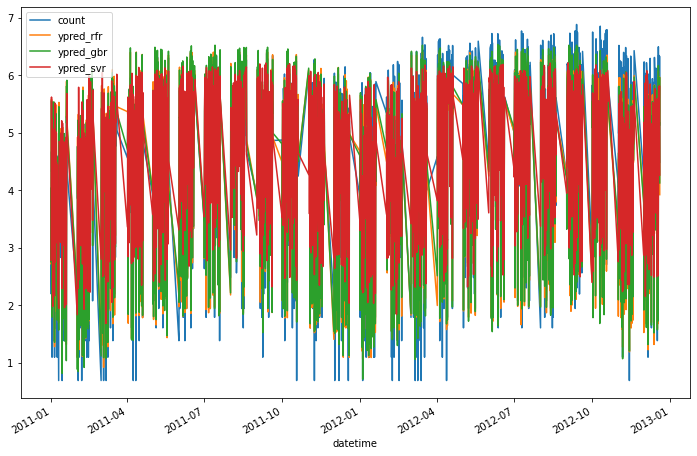

In [64]:
#plot the predictions against the actual values

y_total.plot(figsize=(12,8))

- Features included: 'temp','hour','weather','weekday','holiday'
-  RFR()
    -  RSMLE=0.49
    - R²_train=0.93
- after GridSearch: RFR (max_depth=10, n_estimators=100)
    - RSMLE=0.469 (kaggle 0.489), 
    - R²_test=1.0, 
    - R²_train=0.851
- with TPOT:
    - RSMLE=0.475
    - R²_train=0.851
    - R²_test=1.0 
- SVR
- GBR